<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# N-grams, Fastttext, and GloVE

This assignment focuses on exploring Fasttext and GloVE as NLP methods. We are going to focus on two tasks and ways of understanding models:

1. The traditional, "model is a classifier" viewpoint. Here we are going to work with the [AG News Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) to classify genres
2. The more vector-based way, seeing them basically as machines that just generate word vectors, with everything else just being gravy. Barring attaching a specific classifier, GloVE falls entirely under this category.

In this assignment, we are mainly going to be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset), a corpus of more than 1 million news articles, each classified as one of four classes: 'Business', 'Sci/Tech', 'World', or 'Sports'. Note, that because of the semi-supervised nature of most methods used in this assignment, we could almost do the whole thing without the labels. They're just there to make it a bit simpler and to provide an obvious usecase.

**For the GloVe part, note that you can download all their pretrained vectors at the [GloVe project page](https://nlp.stanford.edu/projects/glove/).**

## Extra primer on Fasttext

As you know, n-grams are pretty useful for improving the otherwise limited bag-of-words (BoW) model. Most often, this is by making distinctions between sentences such as "good" and "not good" which would be represented somewhat the same in a regular BoW. It is very obvious if we consider the sentence "Maria stole the milk" vs "The milk stole Maria", two sentences completely identical in the BoW representation, but with two obviously different meanings.

As you also know, Fasttext takes this further by creating chracter-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to consider cases such as grammar, where words are spelled similarly and even consider misspellings, if someone makes a mistaek in wirtign a wrod, the character-wise n-gram representation will be **almost** the same as the correct word.

This is done by Fasttext simply storing embedding vectors $v_n$ for each n-gram, character or otherwise. Fasttext will simply then average all of these vectors, word, character-wise n-grams, and word-wise n-grams to create the representation for a given text or sentence.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

### Important note: Fasttext supervised and unsupervised

If you look into the technical documentation for the fasttext model, you'll notice that there are options to train both an **unsupervised** and a **supervised** version of the fasttext model. These use similar approaches, but it is arguably the unsupervised model that best describes what the fasttext team wanted to accomplish: efficient word-vector generation for downstream usage.

***The supervised model:***
- Needs a corpus of text with given labels to train
- Does not use skipgram/CBoW, but just works as a 'normal' FFN for classification
- Uses character-wise n-grams
- Uses word-wise n-grams the same way as the unsupervised model uses character-wise n-grams, treating them as vectors and combining them in the end for the final classification.
- Can be directly evaluated by just checking how good it is at predicting the given classes.

***The unsupervised model:*** (not important for this assignment or course, just cool to know)
- Just needs a corpus of text to train
- Does not use wordwise n-grams
- Has vectors for each unique character n-gram and each unique word in the corpus (limited by bin size)
- Vectors for character n-grams are created indepedently of word vectors, for example the trigram "her" present in "where" has a different vector representation than the one for the full word "her".
- Is a purely skipgram/CBoW model (input layer, one hidden, output layer)
- Cannot be directly evaluated except in qualitative ways by considering the downstream tasks it will be used in


***Both models***
- Only work on CPU (bvadr) (what a time 2015 was!)

</span>

In [1]:
import numpy as np
import string
import random
import re
import pickle
import fasttext

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
def generate_seed():
    """
    Generates robust seed values using methods adapted from Gaius-quantum reverse...
    ...GaunTLets, see more https://isotropic.org/papers/chicken.pdf and explained https://www.youtube.com/watch?v=dQw4w9WgXcQ
    Values are generated from a specific subset of alphanumerics representing sub-deca natural-numericals
    from the glove.42B.300d.txt Use this subset for the reverse function as well, the whole one will take too long
    """

    with open("important_stuff.pkl", "rb") as fp:
        GQRGaunTLets_69B_300_seed_vals = pickle.load(fp)
        seed = int(np.var(GQRGaunTLets_69B_300_seed_vals[69]) * 100)
        return seed

def seed_everything(seed_value):
    import torch
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(generate_seed())

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 1 Word- and character-wise n-grams

The selling point of fasttext is in part given by its main paper's name: **Enriching Word Vectors with Subword Information**.  Character n-grams is really all its about. Since you have already worked with them, we are just going to briefly introduce them

Normally, getting N-grams would be something you'd leave for an NLP package like NLTK. We're just going to implement it for the sake of understanding.

#### **1.1.💻 Implement the below functions to get word-grams and character-grams respectively**

#### **1.2 Test the functions by running the cell two steps below. Based on the output, why do you think fasttext operates with a "bucket size" variable that determines the maximum number of possilbe word-grams available to the model?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Embedding: A numerical representation of objects, as vectors of numbers.

Bucket Size: a variable (usually size 2*10**6, but can be lowered for smaller datasets) used to reduce the memory usage of our model.
When we create n-grams, for large corpora, there could be millions(or more) n-grams, and saving an embedding vector for each of these would demand an infinite amount of memory and would be very inefficient.  
the usage of the bucket is firstly to hash(convert the word to a constant number) each n-gram.
then the algorithm modulates the hash with the bucket variable, which maps the hash to a specifik bucket index. whithout buckethashing, the vocabulary size would be ridiciously large, given that it is dependent on innumerable words, and their many n-grams. by using the buckethashing method we can work with a vocab of a given size, because we control the indexing, which means we have a fixed M-dimensional embedding matrix.
there is the risk of two different n-grams having a hash that modulated with the bucket gives the same index. this is alright tho, because the dimensionality of the bucket is rather high, so the risk of "collision" is low. It's an ML model, it is a god made of iron flesh and powered by zeus, it learns to handle minor collisions. Overall size should negate the occasional collision.



</span>


</span>

In [3]:
def get_character_grams(word, n=3, lower=True, strip=True):
    """
    Gets FastText-style character n-grams for a single word.
    """
    if lower:
        word = word.lower()
    if strip:
        word = re.sub('[^a-z0-9]+', '', word)

    # Add boundary symbols like FastText (<word>)
    word = f"<{word}>"

    # Extract overlapping character n-grams
    return [word[i:i+n] for i in range(len(word) - n + 1)]


def get_word_grams(text, n=3, lower=True, strip=True):
    """
    Gets FastText-style character n-grams for every word in a text.
    """
    words = re.findall(r"\b\w+\b", text)
    all_ngrams = []

    for word in words:
        char_grams = get_character_grams(word, n=n, lower=lower, strip=strip)
        all_ngrams.extend(char_grams)

    return all_ngrams


In [4]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=3)


# Vi itererer over de faktiske ord i teksten
words = re.findall(r"\b\w+\b", text)
word_grams = [get_character_grams(w, 3) for w in words]

print("All character trigrams combined:\n", n_grams)
print("\nCharacter trigrams grouped per word:\n", word_grams)

All character trigrams combined:
 ['<he', 'he>', '<tu', 'tur', 'urn', 'rne', 'ned', 'ed>', '<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>', '<in', 'int', 'nto', 'to>', '<a>', '<pi', 'pic', 'ick', 'ckl', 'kle', 'le>', '<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>', '<sh', 'shi', 'hit', 'it>', '<iv', 'ive', 've>', '<ev', 'eve', 'ver', 'er>', '<se', 'see', 'een', 'en>']

Character trigrams grouped per word:
 [['<he', 'he>'], ['<tu', 'tur', 'urn', 'rne', 'ned', 'ed>'], ['<hi', 'him', 'ims', 'mse', 'sel', 'elf', 'lf>'], ['<in', 'int', 'nto', 'to>'], ['<a>'], ['<pi', 'pic', 'ick', 'ckl', 'kle', 'le>'], ['<fu', 'fun', 'unn', 'nni', 'nie', 'ies', 'est', 'st>'], ['<sh', 'shi', 'hit', 'it>'], ['<iv', 'ive', 've>'], ['<ev', 'eve', 'ver', 'er>'], ['<se', 'see', 'een', 'en>']]


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 2 - Training and using the fasttext model

<p style="text-align:center;">"<i>(Almost) Never do yourself what some other chump has done better"</i> </p>
<p style="text-align:center;"> - Creed of the KID </p>

Obviously someone else has made a pretty well working [Fasttext module](https://fasttext.cc/). In this case, it is the team at Meta (Facebook, back then). Aside from how well it trains, is does have a few weird things about it, most notably that it requires .txt files to train (bvadr).

For this exercise, we are going to focus on just tweaking minn and maxnn which control the minimum and maximum length for the character-grams. Note that setting the minn and maxn length both to 0, makes the model only consider word-grams and word vectors.

A complete list of model hyperparameters can be found in the file hypereparams.txt, along with (most) methods callable on the Fasttext model. Refer to this if you need inspiration on making your model interesting. Consider any chosen hyperparamters **as arbitrary** and feel free to change them as you wish. It helps, however, to comment on or argue for your changes.

Important note: If the model is asked for a word- or character-vector **not in its current vocabulary**, it will give a zero-vector of the same dimension as the other vectors in its vocabulary. This way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 2 - Fasttext Theoretical questions

#### **2.1. In general, how does fasttext handle OOV (out of vocabulary) tokens? How do they contribute to embeddings vectors?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

For a given word that exceeds the vocabulary, its still possible to represent it as a sum of the embeddings of its mixed n-grams, if those are present(most likely) in other words. so there is a small risk of this causing issues, but by smartly grabbing known words, we can still represent the unknown word out of vocab

</span>

#### **2.2. Say you have a fasttext model trained on a large corpus with character-3-grams how would it reprsent the OOV word "Phandelver"?.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

chacter n-gram of phandelver:
[<ph, pha, han, and, nde, del, elv, lve, ver, er>]
,then we would hash each n-gram to their respective buckets, and from our bucket index we find the pretrained embedding vectors, which we then combine to a new vector. because the model uses meaningful representations of the n-grams, our new vector is most likely a sensible guess to it's "true" value. 

</span>

#### **2.3. In probability theory, you often consider either the marignal probability $p(x)$, or the conditional probability $p(x|y)$. How do these two different kinds of probability relate to the field of natural language processing?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

the notation of p(x)(frequence of word in corpus) refers to the propability of some values x, in nlp this is most often a word. the conditional propability p(x|y), is the propability of some x given that y has happened. this can be used to calculate the propalility of some word x occuring given that another word y is before it. By these propabilities we can calculate estimates of words occuring in a sequence, given their prior word. prior propablities are closely related to our understanding of n-grams. for instance we can use a naive bayes classifier model for sentiment analysis, given a class c(positive/negative). 
 
</span>

#### **2.4. Word2Vec is pretty old method in NLP, now mostly supplanted by attention-based models. What disadvantages are there in using specific word vectors for text classification? As inspiration, consider a fasttext model being given the following question:**

*Mary saw a puppy in the window*

*She wanted it.*

*James saw a nice window in the window store*

*He wanted it.*

*What did Mary want?*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Word2Vec: a method to obtain vector representations of words. Vectors capture information of words based on the surrounding words. Vectors are high dimensional and capture relationships by using cosine similarity, and are mapped based on similarity. walk~ran, copenhagen~denmark etc. the model takes a large corpus as input, and oututs a word mapping in a vector space of many dimensions. a single vector represents a word in the corpus.

in the context question we are aware of to characters who both want something. Given the word2vec algorithm we embed the words and make them vectors(static). here we get issues when refering to something, since in case of boty Mary and James want *it*, which we can infer to be the puppy and the window, but our machine has no clues, since it uses the same vector. 
the main issues of the word2vec method is its limitation to the corpus, since it only learn relationships in the given corpus, so if a word not in corpus appears we have no way to represent it. 
secondly, all vectors are static, meaning each word only has one vector to it, so words with meanings more than one are badly represented. Context also looses out in this method. 


</span>

#### **2.5. Because of the way fasttext generates word-vectors (skipgram/CBoW), it only ever considers local contexts and not whole corpora at a time. What potential downsides does this have?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Focusing on only local context means a loss of "global" meaning, so based on the window we generate our vectors we can lose information, such as semantics or tone. same words but in different context will have blended representations("she's hot", "the stove is hot")
This approach can only find short patterns, there's no possibilty of finding tone, style or topic

</span>

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Boilerplate here - feel free to ignore

Not important what we do here, but for those roughly we do in order:

1. Load the AG news dataset
   1. This is a kind of dictionary object, so we can subindex the train, and test texts, and labels.
2. We ensure that the proportions of label classes are roughly equal in the train and test cases
   1. If they were unequal (more sports in train than in test, for example), we could still solve the problem, but it would significantly harder, since this would encourage the model to be extra sensetive to one class over others.
3. We then create our .txt file that the fasttext model will use by:
   1. Making all text lowercase
   2. Removing all special characters (non-alphanumerics)
   3. Adding labels to the beginning of texts with a `__label__{label}` tag


</span>

In [5]:
from datasets import load_dataset

# Load AG_news data
ds = load_dataset("ag_news")

train_texts = [ex["text"] for ex in ds["train"]]
test_texts  = [ex["text"]  for ex in ds["test"]]
train_labels = np.array([ex["label"] for ex in ds["train"]], dtype=np.int64)
test_labels  = np.array([ex["label"] for ex in ds["test"]],  dtype=np.int64)
ag_news_labels = ds["train"].features["label"].names  # list of label names

np.savez("news_data.npz",
         train_texts=train_texts,
         test_texts=test_texts,
         train_labels=train_labels,
         test_labels=test_labels,
         ag_news_labels=ag_news_labels)

print("Saved `news_data.npz` with keys:", list(np.load("news_data.npz").keys()))

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
        f"{len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)},\n"
        f"these correspond to the categories: {ag_news_labels}\n")


# Let's just ensure class proportions are balanced for both training and testing purposes...
n_classes = len(ag_news_labels)
print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))
print()

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))


Saved `news_data.npz` with keys: ['train_texts', 'test_texts', 'train_labels', 'test_labels', 'ag_news_labels']
There are a total of 120000 data points in the dataset, 
7600 different points in the test set, and the different labels are [0 1 2 3],
these correspond to the categories: ['World', 'Sports', 'Business', 'Sci/Tech']

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tech 0.25

Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tech 0.25


In [6]:
# Creating fasttext data set from current training data
def txtify_data(texts, labels, label_names, save_path):
    """
    Converts a list of texts and labels to a .txt file compatible with fasttext

    Args:
        texts (np.ndarray): Train texts to be converted to .txt
        labels (np.ndarray): Train labels so that label i corresponds to text i
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
        save_path (str): Path where the txt file will be saved so fasttext can use it

    Returns:
        _type_: _description_
    """

    txt = ""
    for i, (text, label) in tqdm(enumerate(zip(texts, labels))):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]+', '', text)

        txt = txt + f'__label__{label_names[label]} {text}\n'

    
    f = open(save_path, mode='w')
    f.write(txt)
    f.close()

    return save_path

path_to_train = txtify_data(train_texts, train_labels, ag_news_labels, save_path='data/training_data.txt')
path_to_test = txtify_data(test_texts, test_labels, ag_news_labels, save_path='data/test_data.txt')

120000it [00:42, 2855.52it/s]
7600it [00:00, 54822.41it/s]


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Training fasttext - It's that easy

In the below cell, we train a fasttext character model and a fasttext word model. The word model is trained by simply setting `maxn` and `minn` (the max and minimum length of character grams) to $0$.

After this, there are a bunch of convenient functions we can use on the resulting `FastText` object. Since we train *supervised* models, we are able to get the model's prediction for what genre a certain text is, which we do two cells below with the `test_prediction` function.

You are of course welcome to mess around with the values of `char_gram_length_min`, `char_gram_length_max` and `num_word_grams`, and indeed any other hyperparameters, as you please.

</span>

In [7]:
# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

# Train fasttext_word_model and fasttext_char_model respectively
fasttext_word_model = fasttext.train_supervised(path_to_train, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)

fasttext_char_model = fasttext.train_supervised(path_to_train, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

In [8]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print("Word model subwords:", fasttext_word_model.get_subwords('cat'))
print("Character model subwords:", fasttext_char_model.get_subwords('cat'))

Word model subwords: (['cat'], array([4986]))
Character model subwords: (['cat', '<ca', '<cat', '<cat>', 'cat', 'cat>', 'at>'], array([   4986, 1018917, 2091143, 1530307,  391201, 1230165,  453276]))


In [9]:
def test_prediction(model, test_text, test_label=None, return_bool=True):
    """
    test labels and return_bool used for when we need accuracy of the model
    Method for testing fasttext model
    Model should be either the character model or the word model

    Args:
        model (fasttext model): Model to be tested
        test_text (str): Text to be tested
        test_label (str): Label of the text, used for testing accuracy
        return_bool (bool): If true, returns a boolean indicating if the prediction was correct, else returns the prediction
    """

    # Reason why we index with [0][0][9:] we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
    prediction = model.predict(test_text)[0][0][9:]

    if not return_bool:
        return prediction

    if prediction == test_label:
        return True

    return False

# Testing the models on some toy data
text_to_predict = 'A cat in a hat'
prediction = test_prediction(model=fasttext_word_model, test_text=text_to_predict, return_bool=False)
print(f"{text_to_predict}: {prediction}")

A cat in a hat: Sci/Tech


In [10]:
old_data = np.load("news_data.npz", allow_pickle=True)
new_data = load_dataset("ag_news")

# Compare saved .npz data with freshly loaded dataset

old_train_texts = list(old_data["train_texts"])
old_test_texts  = list(old_data["test_texts"])
old_train_labels = np.array(old_data["train_labels"])
old_test_labels  = np.array(old_data["test_labels"])
old_label_names  = list(old_data["ag_news_labels"])

new_train_texts = [ex["text"] for ex in new_data["train"]]
new_test_texts  = [ex["text"] for ex in new_data["test"]]
new_train_labels = np.array([ex["label"] for ex in new_data["train"]], dtype=np.int64)
new_test_labels  = np.array([ex["label"] for ex in new_data["test"]], dtype=np.int64)
new_label_names  = new_data["train"].features["label"].names

def compare_lists(a, b, name, show_mismatches=5):
    same_len = len(a) == len(b)
    equal_all = same_len and all(x == y for x, y in zip(a, b))
    print(f"{name}: length old={len(a)}, new={len(b)}; identical={equal_all}")
    if not equal_all:
        print(" Showing up to", show_mismatches, "differences (index, old_preview, new_preview):")
        cnt = 0
        for i, (x, y) in enumerate(zip(a, b)):
            if x != y:
                print(i, repr(x)[:120], "...", repr(y)[:120])
                cnt += 1
                if cnt >= show_mismatches:
                    break
        # if lengths differ, show tail/extra items
        if len(a) != len(b):
            if len(a) > len(b):
                print("Extra items in old at indices:", list(range(len(b), min(len(a), len(b)+show_mismatches))))
            else:
                print("Extra items in new at indices:", list(range(len(a), min(len(b), len(a)+show_mismatches))))

# Compare texts and labels
compare_lists(old_train_texts, new_train_texts, "Train texts")
compare_lists(old_test_texts,  new_test_texts,  "Test  texts")

print("Train labels identical:", np.array_equal(old_train_labels, new_train_labels))
print("Test  labels identical:", np.array_equal(old_test_labels,  new_test_labels))

print("Label names old:", old_label_names)
print("Label names new:", new_label_names)
print("Label names identical:", old_label_names == new_label_names)


Train texts: length old=120000, new=120000; identical=True
Test  texts: length old=7600, new=7600; identical=True
Train labels identical: True
Test  labels identical: True
Label names old: ['World', 'Sports', 'Business', 'Sci/Tech']
Label names new: ['World', 'Sports', 'Business', 'Sci/Tech']
Label names identical: True


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 - Getting Fasttext Accuracy

Now that we have a way of training both a fasttext character model, and a fasttext word model, we would like a function that goes through our test texts and labels, and outputs the fasttext model's accuracy on the given test set

#### **3.1. 💻 Implement the below function to get the accuracy of a fasttext model. It should return the accuracy of the fasttext model when trying to predict each of the four labels, as well as the average accuracy across all labels. You can use the test_prediction function above to get predictions, but you can also implement your own method.**

#### **3.2. There shouldn't be *that* big of a difference in performance between the character model and word model when predicting the genres of these texts... why do you think that is?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

There's a rather big difference between the two models, both in computation and accuracy. whilst the word model is very quick, it also has worse accuracy. the word model takes about 0.15 seconds to complete, whilst the character model takes upwards 1.5 seconds, but it has a greater accuracy, which is what we would expect from this model since it's more robust to gramatical errors and inflections.
so we found that there is a rather big difference in performance (accuracy/computation) 

</span>


</span>


In [11]:
import time
def test_fasttext_model(fasttext_model, test_texts, test_labels, label_names):
    start_time = time.time()
    """
    Tests FastText model accuracy on each label and overall.
    Works with numeric test_labels (0–3) and FastText string labels.
    """
    # Initialize counters. Supports label_names as array-like of strings
    # or dict mapping int->str (in which case iterating yields keys -> ints).
    # We want keys to be the label names for per-label counters.
    if isinstance(label_names, dict):
        names_iter = label_names.values()
    else:
        names_iter = label_names

    correct_per_label = {name: 0 for name in names_iter}
    total_per_label = {name: 0 for name in names_iter}

    for text, true_label in zip(test_texts, test_labels):
        true_label_name = label_names[int(true_label)]  # convert 0→"World" (works for ndarray or dict)
        pred_label = fasttext_model.predict(text)[0][0]  # "__label__Business"
        pred_label_name = pred_label.replace("__label__", "")

        total_per_label[true_label_name] += 1
        if pred_label_name == true_label_name:
            correct_per_label[true_label_name] += 1

    # Compute per-label accuracies safely (avoid div-by-zero)
    accuracies = {}
    for name in total_per_label:
        if total_per_label[name] > 0:
            accuracies[name] = correct_per_label[name] / total_per_label[name]
        else:
            accuracies[name] = 0.0

    # Overall (weighted) accuracy across all examples
    total_correct = sum(correct_per_label.values())
    total_examples = sum(total_per_label.values())
    accuracies["average_accuracy"] = total_correct / total_examples if total_examples > 0 else 0.0
    end_time = time.time()
    return accuracies, f"Model testing completed in {end_time - start_time:.2f} seconds"


print("Testing fasttext word model...")
print(test_fasttext_model(fasttext_word_model, test_texts, test_labels, ag_news_labels))

print("\nTesting fasttext character model...")
print(test_fasttext_model(fasttext_char_model, test_texts, test_labels, ag_news_labels))
print() # tak chat, nu har jeg det meget beere. det var så lidt *maskingeværdslyde*


Testing fasttext word model...
({'World': 0.7568421052631579, 'Sports': 0.8142105263157895, 'Business': 0.8157894736842105, 'Sci/Tech': 0.7694736842105263, 'average_accuracy': 0.7890789473684211}, 'Model testing completed in 0.15 seconds')

Testing fasttext character model...
({'World': 0.8568421052631578, 'Sports': 0.9457894736842105, 'Business': 0.8594736842105263, 'Sci/Tech': 0.8573684210526316, 'average_accuracy': 0.8798684210526316}, 'Model testing completed in 1.23 seconds')



<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 3 - GloVe to create embeddings vectors

*[GloVe Paper here](https://aclanthology.org/D14-1162.pdf), [GloVe Project page here](https://nlp.stanford.edu/projects/glove/)*

GloVe is called a "global log-bilinear regression model" which combines the strengths of global matrix factorization and local context window methods.

In plain English, this means it combines methods that work by collecting information on the entire corpus, with other methods that capture more local patterns, essentially what we see with Fasttext that considers local n-grams. GloVe just considers "context windows" rather than an n-gram. Overall, what they want are nicely defined, linear relationships, decided by comparing the co-occurences of different words.

The selling point really, is that while a run-of-the-mill neural network **may** be able to answer the questions: "Skibidi is to Toilet as Fanum is to ...?", it will not necessarily be able to do it in a linear manner. Therefore considering all the word vectors together in their latent space, may not yield good information. GloVe fixes this by keeping all vector substructures linear.

Essentially, GloVe trains by mixing a [Skipgram model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) (just a neural network) with a function that works more on the entire corpus, while maintaining a weighting between the two. Because GloVe works best on huge corpora of data, we are not going to train it ourselves, but just use pretrained GloVe vectors, collected from their [project page](https://nlp.stanford.edu/projects/glove/).

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4  - GloVe Theoretical questions


#### **4.1. On their project page, GloVe gives a few different possibilities for GloVe vectors, including ones with embedding dimension 50, 100, 200, and 300. What potential downsides and upsides are there to larger/smaller embedding dimensions? Consider both training and subsequent usage.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Higher dimension embeddings occasionally overestimate the semantic similarity between antonyms(antiwords). in general:
higher dimension; more representational power, but risk of overfitting  and higher cost. smaller dimensions: faster, cheaper and decent for small tasks, risk of underfitting. 

</span>

#### **4.2. Also on their webage, they give two options for the "Common Crawl" GloVe vector set: "42B tokens, 1.9M vocab, 300d vectors" and "840B tokens, 2.2M vocab, 300d vectors". What are the differences between these?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Common Crawl is a large dataset gathered from the internet. The difference between the two sets is mostly the data size (token amount). An important detail to note is however that the text was not lowercased for the larger vocabulary, making the results not directly comparable. 

</span>

#### **4.3. GloVE is presented purely as an embedding model, without any sort of infrastructure to support classification, generation, or anything of the sort. Why is such an only-embedding model still valuable??**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Because it's an effectient method of vectorizing the corpus, and ís a great base for creating classification models and all that. 

</span>

#### **4.4. In the GloVe paper, they say they attempt to model $F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_jk}$. That is, the probability of one word given another, compared to the probability of that same word given a third word. For this, they briefly consider using a neural network as the function $F$ but decide against it, as "doing so would obfuscate the linear strcutures we are trying to capture", what linear structures are talked about and how would they be obfuscated by using something like a neural network?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

a NN would "obfuscate" the data, because it uses non-linear transformations, and that would make the semantic relationsships non-linear and complicated. Non-linearity would maje it hard to directly interpret the learned vector differences as meaningful direction, we would lose the simple linear structure, that allows us to use vector maths to express relations



</span>


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

`load_glove` and `create_GloVE_vector` below, are functions to load and create convenient data structures from our GloVE file, and create a combined GLoVE vector from a longer text in much the same way FastText does, respectively.

</span>

In [12]:
def load_glove(glove_path):
    """
    Loads GloVe vectors robustly, trying utf-8 then falling back to latin-1.
    Returns: dict[word] = np.ndarray(float32)
    """
    glove = {}
    encodings = ['utf-8', 'latin-1']
    for enc in encodings:
        try:
            with open(glove_path, 'r', encoding=enc, errors='strict') as f:
                print(f"Creating GloVE dictionary using encoding: {enc}")
                for line in tqdm(f):
                    parts = line.rstrip().split(' ')
                    if len(parts) < 2:
                        continue
                    word = parts[0]
                    vec = np.asarray(parts[1:], dtype='float32')
                    glove[word] = vec
            return glove
        except UnicodeDecodeError:
            # try next encoding
            continue
        except Exception:
            # if other errors occur, try a permissive open with replace
            break

    # last-resort permissive open
    with open(glove_path, 'r', encoding='utf-8', errors='replace') as f:
        print("Creating GloVE dictionary using permissive open (errors='replace').")
        for line in tqdm(f):
            parts = line.rstrip().split(' ')
            if len(parts) < 2:
                continue
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            glove[word] = vec

    return glove

def create_GloVE_vector(text, glove):
    """
    Creates a GloVe vector for a longer text by averaging word vectors.
    Returns a vector of same shape as glove entries (or zeros if none found).
    """
    text = text.lower()
    text = re.sub('[^a-z0-9 ]+', '', text)
    words = text.split()

    # If glove is empty, raise informative error
    if not glove:
        raise ValueError("`glove` dictionary is empty. Load GloVe first with `load_glove`.")

    placeholder = np.zeros_like(next(iter(glove.values())))
    vectors = [glove[word] for word in words if word in glove]

    if not vectors:
        return placeholder.copy()

    # Stack vectors and compute mean across axis=0
    avg = np.mean(np.stack(vectors, axis=0), axis=0)
    return avg

In [13]:
# Load GloVe dictionary, doing it here since we only wanna do it once, since it takes a fuckton of time
glove = load_glove('glove.6B.50d.txt')

Creating GloVE dictionary using encoding: utf-8


400000it [00:06, 65634.57it/s]


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 5 - Word similarity

#### **5.1. 💻 Complete the `word_similarity` function below. It should compute the cosine simliarity between two provided word embedding vectors.**


#### **5.2. Briefly comment on the similarities obtained when running the cell two spaces below**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

GloVe similarity between cat and dog is 0.921800434589386
GloVe similarity between cat and banana is 0.3396517336368561
GloVe similarity between cat and cat is 0.9999998807907104
GloVe similarity between camera and man is 0.47356218099594116
GloVe similarity between steel and beams is 0.5590428709983826
GloVe similarity between six and 6 is 0.7447779774665833

most of the similarities makes sense in their relation. though its funny how six and 6 are not that similar, but that must be because of the context in which we use the two methods of typing out "six/6" 

</span>

</span>

In [14]:
def word_similarity(vec1, vec2, glove=None):
    """
    Gets the cosine similarity between two vectors or two words in the GloVE dictionary

    Args:
        vec1 (np.ndarray, str): First vector to compare to the second
        vec2 (np.ndarray, str): Second vector to compare to the first
        glove (dict): GloVe dictionary if we want to compare words instead of just vectors, else None

    Returns:
        float: Cosine similarity of the two vectors or words
    """

    # Get the vectors from the GloVE dictionary if the input is a string
    if glove is not None:
        vec1, vec2 = glove[vec1], glove[vec2]
    
    # Return the cosine similarity of the two vectors
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


In [15]:
# Test the word simliarity function on some word pairs

word_pairs = [('cat', 'dog'), ('cat', 'banana'), ('cat', 'cat'), ('camera', 'man'), ('steel', 'beams'), ('six', '6')]

for word1, word2 in word_pairs:
    print(f"GloVe similarity between {word1} and {word2} is {word_similarity(word1, word2, glove)}")

GloVe similarity between cat and dog is 0.921800434589386
GloVe similarity between cat and banana is 0.3396517336368561
GloVe similarity between cat and cat is 0.9999998807907104
GloVe similarity between camera and man is 0.47356218099594116
GloVe similarity between steel and beams is 0.5590428709983826
GloVe similarity between six and 6 is 0.7447779774665833


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6 - Comparing word embeddings vectors

Since both GloVe and Fasttext, at their core, are both methods for egenerating embedding vectors, it would make sense to examine how they look compared to one another. Since both live in high-dimensional spaces, we must perform PCA on them to actually make sense of them in a graphical way.

#### **6.1 Explain in a manner you find most fitting: *What are word embeddings?***

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Word embeddings are numbers that represent words. Each word gets a vector, and words that mean similar things end up close to each other in this vector space. since computers can not prossece letters and words then it is a way for computers to understand relationships between words.

</span>


#### **6.2. Explain shortly what you expect to find if we perform PCA on the matrix of word-embeddings, that is the matrix which holds a vector representation of each word in our vocabulary**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

If we run PCA, we’ll squeeze the high-dimensional embeddings into 2D. In theori we should see that similar words ending up close to each other, and The greater the difference in words the more spread out they will be. Basically, PCA helps us visualize the structure of the embedding space.

</span>


#### **6.3. When getting vectors for all words in a large text, GloVe should be significantly faster than Fasttext, why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

GloVe is fast because each word already has its own vector stored, therfore you just look it up.
FastText is slower because it builds a word’s vector from lots of smaller pieces. This takes extra computation every time you ask for a word’s embedding.

</span>

#### **6.4. Which model (GloVe or fasttext) do you think performs best at seperating the four classes of the AG News dataset if we get average embedding vectors for each text in the training and testing dataset, perform PCA on these and plot them on the two top principal components. And why do you think that model performs best at seperating the four classes?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

FastText will probably separate the classes better.
That’s because FastText understands words through their subword parts, this makes it so that it handles rare words, names, and technical terms better, because all of thise types of words show up a lot in news articles. When you average these richer vectors across a whole text and then do PCA, the categories tend to be easier to tell apart.

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 7 - PCA on word embeddings

We now examine how the words conatined in the four different classes look when projected unto a 2-d space.


#### **7.1 Run the code in the two cells below, what does it do overall? What kind of plots does it produce?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

clean_text: Removes all punctuation, and only keeps letters and numbers, and then lowers all letters
get_average_embedding_vectors: 1. if a word is not in the model, a null-vector is created in the shape of the "the" vector. 2. the text is reduced to letters and numbers. 3. if fetattr = checks for an embedding, if false, it uses the placeholder, else it uses the embedded vector
4. do same for test

prior we got the average of all embeddings, which we use as the input for our pca-plotfunction.
firstly we do a plot of the training set, then the test set
the plots are:
pca1 v pc2, pc2 v pc3, pc3 v pc4, and finally the explained variance of the data.


</span>


#### **7.2 Why would we be interested in making exactly these plots?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

we seek to understand if the embedding creates different classes. the pca showcases where our classes are, and if theres any overlap. so we can visually see if there are clusters, outliers and even detect sub-structures in the data. 

</span>

#### **7.3 Change the `current_model` from `glove` to either `fasttext_char_model` or `fasttext_word_model`, does the result change? If so, how?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

the three models value the different classes differently in their values. while the fasttext models(char/word) are somewhat similar, the glove model has a completely different interpretation of the classes, they even seem to be inverse in how they are represented in the pca plots (this can be because of the axis the pca was made with, not neccesarily because they are very different). the main difference, if we disregard the inversion, is the overlap between classes.


</span>

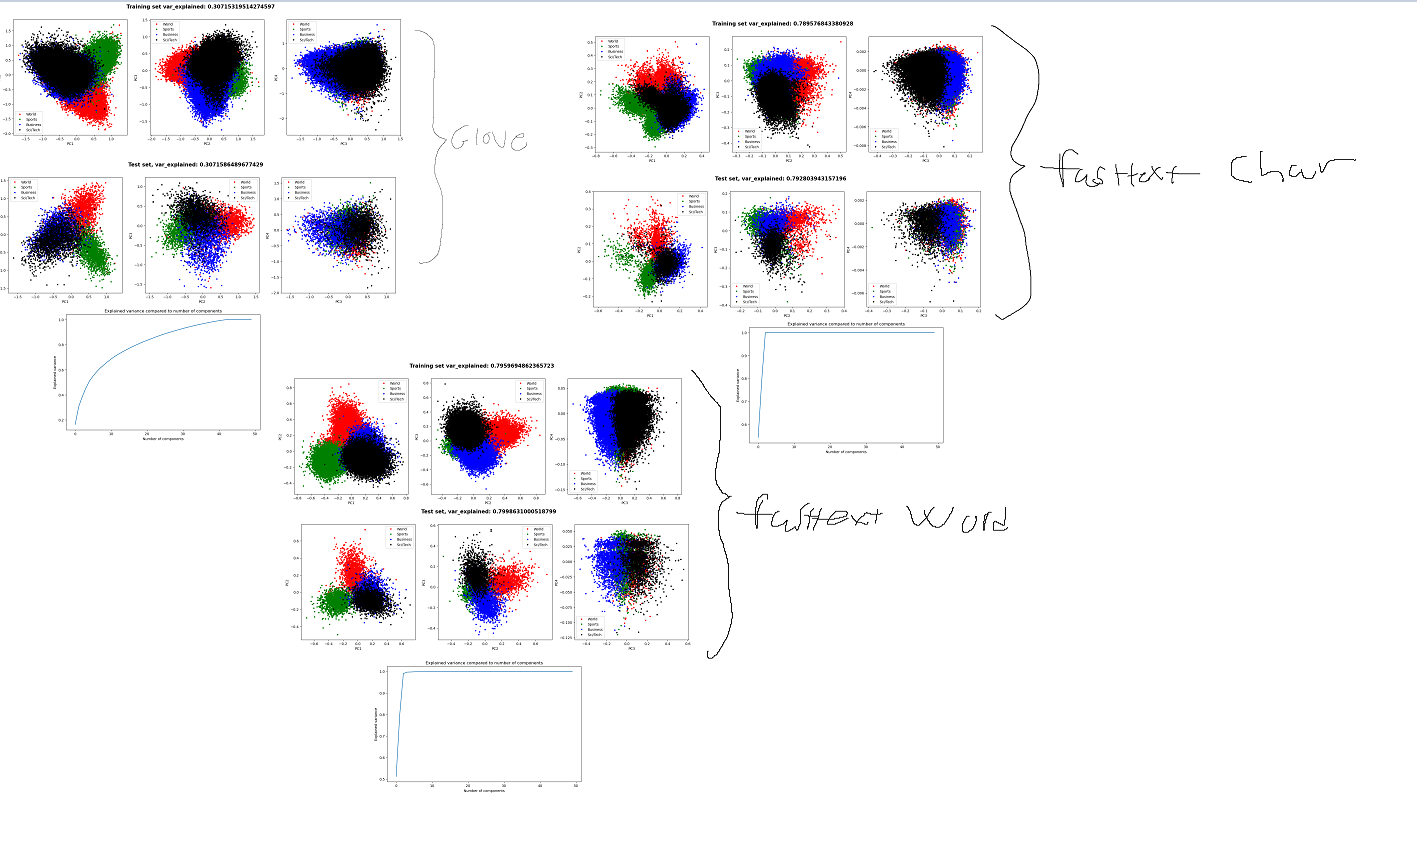

In [43]:
current_model = glove
# current_model = fasttext_char_model
# current_model = fasttext_word_model

In [44]:
feats_train = []
feats_test = []

def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    Just for convenience in regards to GloVe and useful word vectors
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

def get_average_embedding_vectors(model, train_texts, test_texts):
    print("Getting fasttext average embedding vectors for each class...")
    placeholder = np.zeros_like(glove['the'])

    for text in tqdm(train_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_train.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_train.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    # Same but for each text in test set
    for text in tqdm(test_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_test.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_test.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    return np.array(feats_train), np.array(feats_test)

feats_train, feats_test = get_average_embedding_vectors(current_model, train_texts, test_texts)

Getting fasttext average embedding vectors for each class...


  0%|          | 0/120000 [00:00<?, ?it/s]

100%|██████████| 7600/7600 [00:00<00:00, 18472.72it/s]


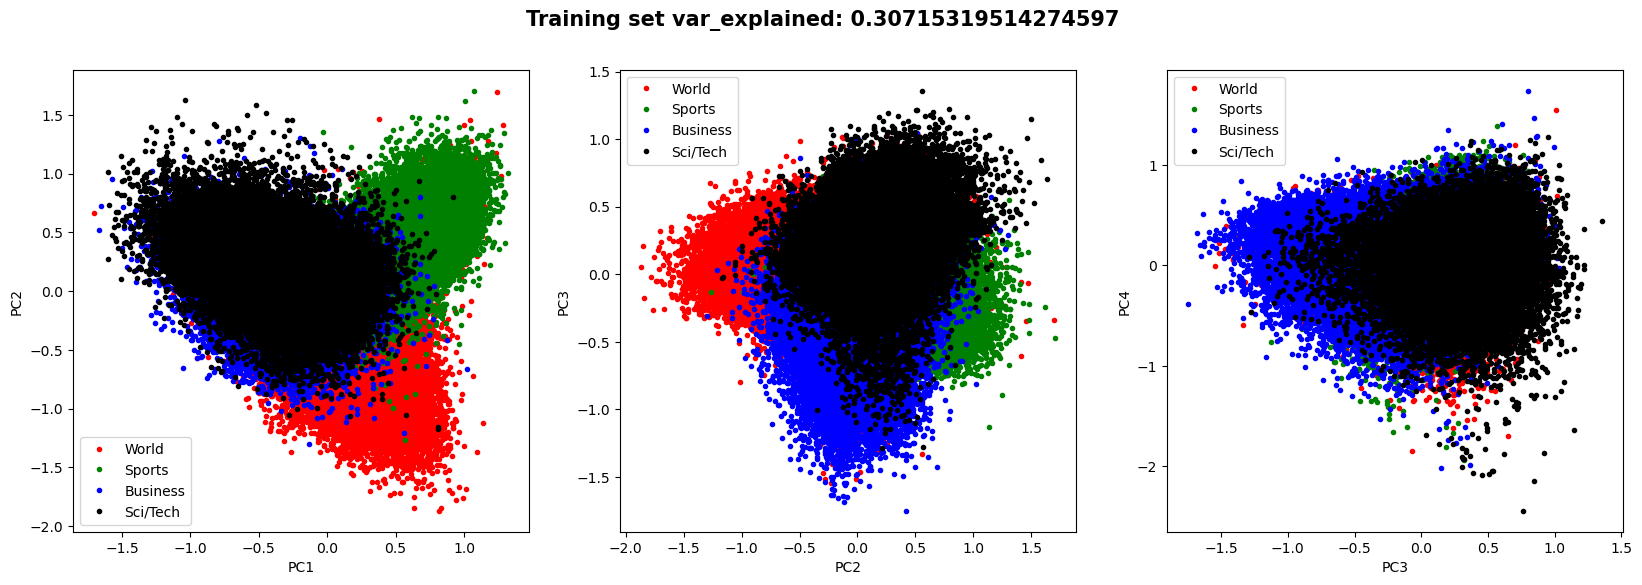

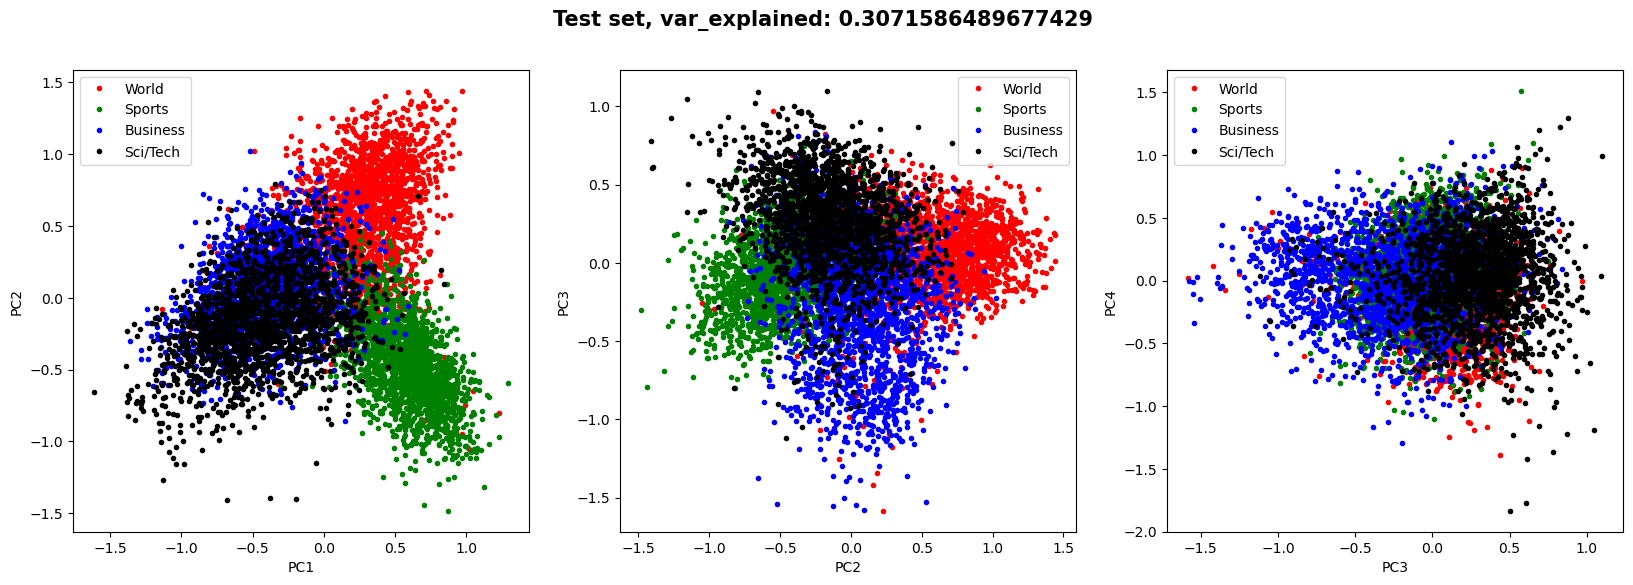

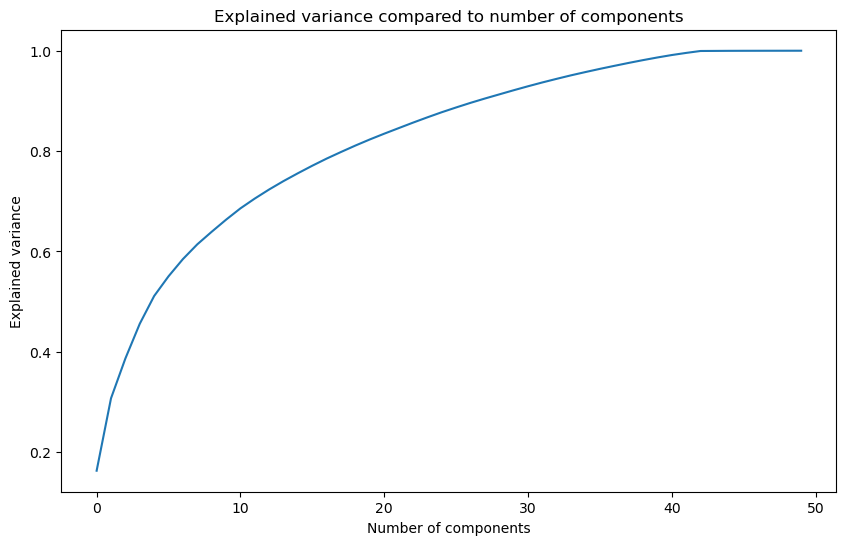

In [45]:
def plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, label_names):
    """
    Does PCA with n_components on given features and plots the result in two dimensions

    Args:
        n_components (int): How many components to use in the PCA
        feats_train (np.ndarray): Average embedding vectors for each text in the training set
        feats_test (np.ndarray): Average embedding vectors for each text in the test set
        train_labels (np.ndarray): Labels for each text in the training set
        test_labels (np.ndarray): Labels for each text in the test set
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    pca = PCA(n_components=n_components)

    # fit_transform avoids having to manually transform the vectors with the matrix afterwards
    Vtrain = pca.fit_transform(feats_train)
    Vtrain_var_explained = pca.explained_variance_ratio_

    Vtest = pca.fit_transform(feats_test)
    Vtest_var_explained = pca.explained_variance_ratio_

    colors = 'rgbk'
    for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], [f'Training set var_explained: {sum(Vtrain_var_explained[:2])}', f'Test set, var_explained: {sum(Vtest_var_explained[:2])}']):
        plt.figure(figsize=(20, 6))
        plt.subplot(1, 3, 1)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        plt.subplot(1, 3, 2)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC2')
        plt.ylabel('PC3')

        plt.subplot(1, 3, 3)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC3')
        plt.ylabel('PC4')
        plt.suptitle(title, fontweight='bold', fontsize=15)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(n_components)),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Explained variance compared to number of components")
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.show()
    
    return pca

n_components = 50
pca_word_vec = plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, ag_news_labels)



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 8 - Getting PCA vectors of single words

Previously, we considered the whole space of words together when projected unto 2 principal components. We can also be interested in doing this with just single words...


#### **8.1 💻 Complete the function `get_vector_transform` below to get a word vector a word and project it to a given PCA with n principal components**


#### **8.2. Comment on the plot created two cells below. Do the vectors correspond to what you'd expect?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

ye somewhat, the words we recognize as similar are also closely related in the plot, though im somewhat perplexed at the distance between "business" and "software" being the same distance as "animals"(closely). 


</span>

#### **8.3. What must we be cognisant of when doing PCA plots like this on $n$ principal components?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

firstly, as mentioned before, pca axes are arbitrary (+/-) and are succeptible to being flipped. 
High dimensional structures do not always represent well in 2 or 3D, so there may be some hidden structure in the plots that are lost because of the dimension. Also, pca assumes linear relationships, so if the embeddings differ in non-linear ways, the pca can fail to show it. mere?

</span>

#### **8.4 Run the cell three steps below to compare different words to the previous list of words. How do they compare? Do these comparisons change significantly when you run with more principal components?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

company-software: 0.9597292542457581
company-business: 0.987724781036377
company-world: -0.8316140174865723

business-software: 0.9040666222572327
business-business: 0.9999998807907104
business-world: -0.9081540703773499

cat-software: 0.4254811108112335
cat-business: -0.0021120579913258553
cat-world: 0.4205531179904938

software-software: 1.0000001192092896
software-business: 0.9040666222572327
software-world: -0.6421104073524475

microsoft-software: 0.9991286993026733
microsoft-business: 0.8854416012763977
microsoft-world: -0.6095563173294067

mouse-software: 0.737216591835022
mouse-business: 0.37772294878959656
mouse-world: 0.04459218680858612

</span>

</span>

In [54]:
def get_vector_transform(word, model, pca, n=2):
    """
    Gets the PCA transformed vector of a given word in the model with n principal components

    Args:
        word (str): word to first get the embedding vector of and then project to PCA space
        model (dict, fasttext model): Either a fasttext model or GloVe dictionary
        pca (sklearn.decomposition.PCA): PCA for the model given, should be the same model as the one used to get the vectors
        n (int, optional): Number of princpal components to project to. Defaults to 2.

    Returns:
        np.ndarray: Word vector of word projected to PCA space with n principal components
    """
    # Get the word vector from the model (glove or Fasttext)
    word_vec = model[word]
    # Reshape so it fits with PCA transform
    word_vec = word_vec.reshape(1, -1)

    # Return the PCA transformed vector with n principal components
    transformed_vec = pca.transform(word_vec)
    return transformed_vec[0, :n]

Text(0, 0.5, 'Latent Semantic dim 2')

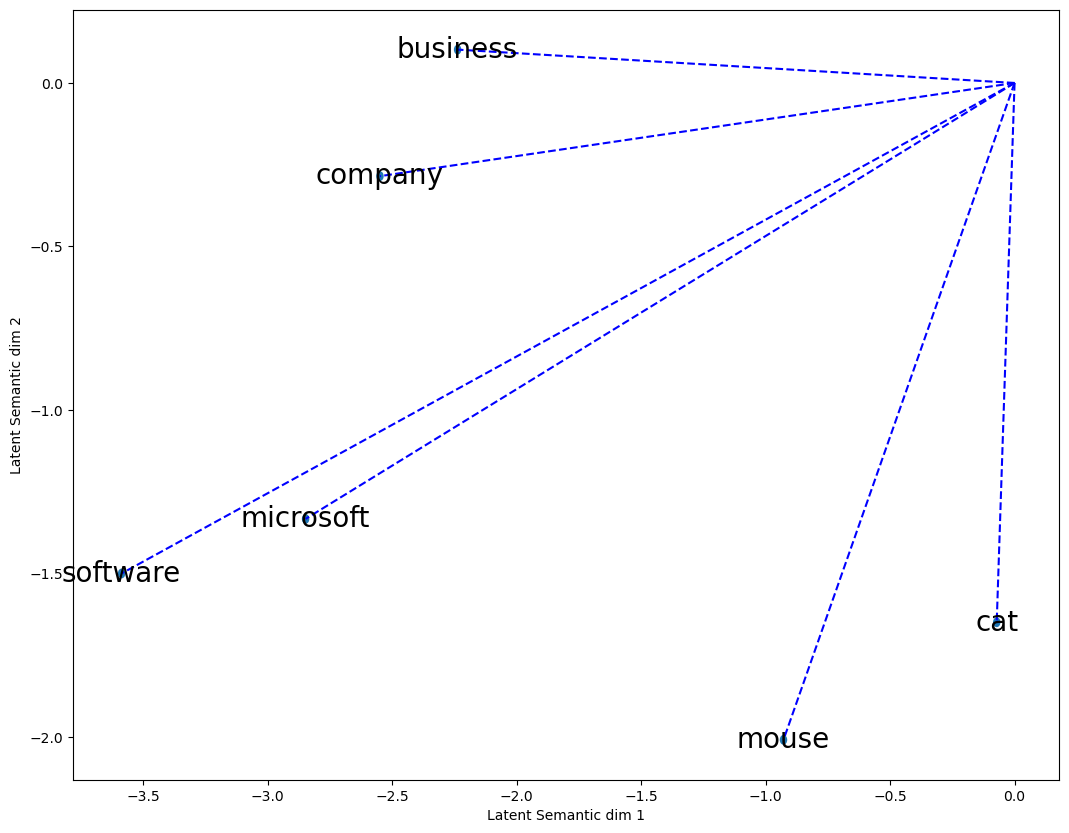

In [53]:
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']

transformed_word_vectors = [get_vector_transform(i, current_model, pca_word_vec, n=2) for i in words]
plt.figure(figsize=(28, 10))
ax = plt.subplot(1, 2, 1)
for idx, vec in enumerate(transformed_word_vectors):
    plt.plot([0, vec[0]], [0, vec[1]], 'b--')
    circle = plt.Circle((vec[0], vec[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(words[idx], xy=(vec[0], vec[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

In [52]:
n = 2

to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        distance = word_similarity(
                                    vec1=get_vector_transform(word, current_model, pca_word_vec, n=2),
                                    vec2=get_vector_transform(comparison, current_model, pca_word_vec,n=2),
                                    glove=None
                                    )
        print(f"{word}-{comparison}: {distance}")
    print()

company-software: 0.9597292542457581
company-business: 0.987724781036377
company-world: -0.8316140174865723

business-software: 0.9040666222572327
business-business: 0.9999998807907104
business-world: -0.9081540703773499

cat-software: 0.4254811108112335
cat-business: -0.0021120579913258553
cat-world: 0.4205531179904938

software-software: 1.0000001192092896
software-business: 0.9040666222572327
software-world: -0.6421104073524475

microsoft-software: 0.9991286993026733
microsoft-business: 0.8854416012763977
microsoft-world: -0.6095563173294067

mouse-software: 0.737216591835022
mouse-business: 0.37772294878959656
mouse-world: 0.04459218680858612



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 9 - Deliberately fucking up our text

FastText was presented as somewhat gracefully handling OOV words, particularly those spelled wrong.

Below, we define the `dyslexibot` function, which deliberately replaces a certian percentage of characters in our test set with either other random letters, or all kinds of random signs. 

#### **9.1 💻 Test both the fasttext_word_model and the fasttext_char_model on text generated by dyslexibot. Change the $p$ value and perhaps the $\text{extra scuffed}$ option. Try to make the fasttext_word_model as bad as possible while the fasttext_char_model still keeps somewhat good performance. Comment on what you did to achieve this.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

</span>

In [24]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [25]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.10, extra_scuffed=False))

Replacing text


1it [00:00, 58.99it/s]

['have you heard of ths tragedy of darth plagueis the wise']


In [26]:
dyslexitext = dyslexibot(test_texts, p=0.20, extra_scuffed=False)

# Insert your training loop here to calculate the test accuracy on the dyslexitext
# using both the word-wise fasttext and the character-wise fasttext


print("Testing fasttext word model...")
test_fasttext_model(fasttext_word_model, dyslexitext, test_labels, ag_news_labels)

print("\nTesting fasttext character model...")
test_fasttext_model(fasttext_char_model, dyslexitext, test_labels, ag_news_labels)
print()


# # TODO: What it says one line above
# ???????????
# ???????????
# ???????????
# raise NotImplementedError("Test me")

Replacing text


7600it [00:05, 1363.19it/s]


Testing fasttext word model...

Testing fasttext character model...



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 10 - Custom text classification

Finally, because it's fun, (and to show the robustness of fasttext), we can try to make our text and let fasttext classify this as one of the four classes.

Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.

As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes

#### **10.1 What text did you make, and why do you think it was classifed the way it was?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


In [30]:
own_text = "i like turtles and cats and dogs and bananas"

assert own_text != "", "Come on, be creative"

print("The text is classified as: ", fasttext_word_model.predict(own_text))#[0][0][9:])

The text is classified as:  (('__label__Sci/Tech',), array([0.96778405]))


##  $\star$ $\star$ $\star$ Exercise 6 Extremely optional task

**1. It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?**

**Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.**

In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")

#### $\star$ **2.5. As mentioned, attention-based models fix a lot of issues that older Word2Vec models had. Particularly, they do not need N-grams to capture context information. Why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **4.4. Given just a bunch of embedding vectors in a vacuum from a known GloVe embedding, it is usually not possible to get a 1-1 correspondance of what words these vectors were. Why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.4. How would you most closely estabilsh this 1-1 correspondance between given vectors from a known GloVe embedding and their corresponding words?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


# TODO: Consider if this makes sense!

# Replace wiht question along the lines of "Why is this not the most cognisant thing to do?"

#### $\star$ **4.5. Why can't we just use a Python dictionary with vectors as keys and words as values? (essentially a reverse GloVe dictionary)**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


### $\star$ 3.2 GloVe vector word

**1. Implement the function below which, given a GloVe vector for a word, finds what word it was before it was embedded**

**2. Slowly add more words to the 'words' list two cells below. At what point do you reckon a text, transformed to GloVe vectors becomes too long to lookup words for each vector in it?**

$\dots$

**$\star \star$ 3. Why is this method so slow? What factors influence its speed? How could you levearage things like asynchronous execution or multithreading to speed it up?**

$\dots$

**$\star \star \star \star \star$ Implment this asynchronous execution or multithreading**

In [ ]:
def find_closest_word(target_vector, glove_lookup):
    """
    Finds the closest word in the GloVE dictionary to a given vector

    Args:
        target_vector (np.ndarray): Vector to find the closest word to
        glove_lookup (dict): GloVE dictionary to look up the closest word in 

    Returns:
        str: Word in keys of glove_lookup closest to target_vector
    """
    # Define an initial max similarity and closest word (both to be updated)
    ...

    # Iterate over all words in the GloVE dictionary and find the most similar one to the target vector
    ...
    

    # If the similarity is higher than the current max, update the max similarity and closest word
    ...

    return ...

In [ ]:
words = ['cat']

for i, word in enumerate(words):
    word_vector = glove[word]
    closest_word = find_closest_word(word_vector, glove)
    print(f"Closest word found to actual word {words[i]}:", closest_word)